In [1]:
import numpy as np
import torch
import torch.nn as nn
import gc
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import product
from sklearn.manifold import TSNE
from models import  ResNet, ResidualBlock
from utils.visualization import visualize, plot_confusion_matrix, plot_decision_boundaries, plot_tsne_2d, plot_tsne_3d
from utils.data_loader import data_loader, full_data_loader
from utils.utils import save_features, encoding
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torchvision.models import resnet34


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
trained_model_path = "./trained_models/ResNet-final.pth"

# task 1
dataset_colorectal_cancer_path = "./datasets/Colorectal Cancer"
label_tags_colorectal = ["MUS", "NORM", "STR"]

# task 2
dataset_prostate_path = "./datasets/Prostate Cancer"
label_tags_prostate=["gland", "nongland", "tumor"]


dataset_animal_path = "./datasets/Animal Faces"
label_tags_animals = ["cat", "dog", "wild"]


SEED = 42
TEST_SIZE = 0.3
VALIDATION_SIZE = 0.1

# Flags
OPTIMIZE_HYPERPARAMETERS = True
LOAD_TRAINED_MODEL = True
TRAIN_MODEL = False

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ml/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ml/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before

cpu


## Load the data into DataLoader
In this step, data is reshaped and normalized
- Normalization helps eliminate the effects of lighting (brightness, contrast, etc.) and other factors that may affect the image, leading to better training performance.


In [2]:
training_loader, test_loader, test_loader = data_loader(data_path=dataset_colorectal_cancer_path, batch_size=64, test_size=0.3)

## Finding best hyperparameter 
The following code is used to find the best hyperparameters for the model by performing a grid search with various combinations of batch size and learning rate.

In [3]:
# Grid search parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001
num_epochs = 30

if OPTIMIZE_HYPERPARAMETERS:
    grid_search_results = {}

    criterion = nn.CrossEntropyLoss()

    # Perform grid search
    for bs, lr in product(batch_sizes, learning_rates):
        print(f"\nTraining with batch_size={bs}, learning_rate={lr}")

        # Update parameters
        batch_size = bs
        learning_rate = lr

        # Reinitialize model and optimizer
        model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    momentum=momentum,
                                    weight_decay=weight_decay)

        # Training loop
        train_losses = []
        validation_losses = []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                del images, labels, outputs

            # Calculate average training loss for epoch
            train_epoch_loss = running_loss / len(training_loader)
            train_losses.append(train_epoch_loss)

            # Calculate validation loss
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()

            val_epoch_loss = val_running_loss / len(test_loader)
            validation_losses.append(val_epoch_loss)

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

        # Plot training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs Validation Loss (batch_size={bs}, learning_rate={lr})')
        plt.legend()
        plt.show()

        # Store results
        grid_search_results[(bs, lr)] = min(validation_losses)





Training with batch_size=16, learning_rate=0.001


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if OPTIMIZE_HYPERPARAMETERS:
    batch_sizes = [16, 32, 64, 128]
    learning_rates = [0.001, 0.01, 0.05, 0.1]

    # Create a matrix to hold the validation losses
    loss_matrix = np.zeros((len(batch_sizes), len(learning_rates)))

    for i, bs in enumerate(batch_sizes):
        for j, lr in enumerate(learning_rates):
            loss_matrix[i, j] = grid_search_results[(bs, lr)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(loss_matrix, annot=True, fmt=".4f", cmap='coolwarm',
                xticklabels=learning_rates, yticklabels=batch_sizes)
    plt.xlabel('Learning Rate')
    plt.ylabel('Batch Size')
    plt.title('Grid Search Results: Validation Loss for Batch Size and Learning Rate Combinations')
    plt.show()

    best_params = min(grid_search_results.items(), key=lambda x: x[1])
    print(f"\nBest parameters: batch_size={best_params[0][0]}, learning_rate={best_params[0][1]}")
    print(f"Best validation loss: {best_params[1]:.4f}")

## Training the Model

In [8]:
## Training the Model
batch_size = 32
num_epochs = 30
learning_rate = 0.01

model = ResNet(ResidualBlock, [2, 4, 6, 3]).to(device)

if LOAD_TRAINED_MODEL:
    model.load_state_dict(torch.load(trained_model_path,map_location=torch.device(device)))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)

#Train the model
total_step = len(training_loader)

train_validation_loss = []

if not LOAD_TRAINED_MODEL:
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(training_loader):
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # free up memory that is no longer in use
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

      # Validation
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              # move tensors to device
              images = images.to(device)
              labels = labels.to(device)

              # get predictions
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)

              # update total and correct
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # free up memory
              del images, labels, outputs

          print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

      # Calculate and store training loss
      train_loss = 0.0
      with torch.no_grad():
          for images, labels in training_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              train_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          train_loss /= len(training_loader)

      # Calculate and store validation loss
      test_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              test_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          test_loss /= len(test_loader)

      train_validation_loss.append({"train": train_loss, "test": test_loss})

  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_validation_loss) + 1)
  train_losses = [x["train"] for x in train_validation_loss]
  val_losses = [x["test"] for x in train_validation_loss]

  # Calculate mean and std for both losses
  train_mean, train_std = np.mean(train_losses), np.std(train_losses)
  val_mean, val_std = np.mean(val_losses), np.std(val_losses)

  # Filter data within 2 standard deviations
  train_mask = np.abs(train_losses - train_mean) <= 2 * train_std
  val_mask = np.abs(val_losses - val_mean) <= 2 * val_std

  # Plot filtered data
  plt.plot(np.array(epochs)[train_mask], np.array(train_losses)[train_mask],
           color="blue", label='Training Loss')
  plt.plot(np.array(epochs)[val_mask], np.array(val_losses)[val_mask],
           color="orange", label='Test Loss')
  plt.title('Training and Test Loss over Epochs (Within 2σ)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  torch.save(model.state_dict(), trained_model_path)

/var/folders/c3/wjytfz2x4rdfv2bhmlsjy49w0000gn/T/ipykernel_27489/1864704278.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_mode

## Test the model

In [9]:
if TRAIN_MODEL:
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # move tensors to device
            images = images.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # update total and correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # free up memory
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))

## Visualizing TSNE Feature extractions from dataset 1 with custom ResNet-34

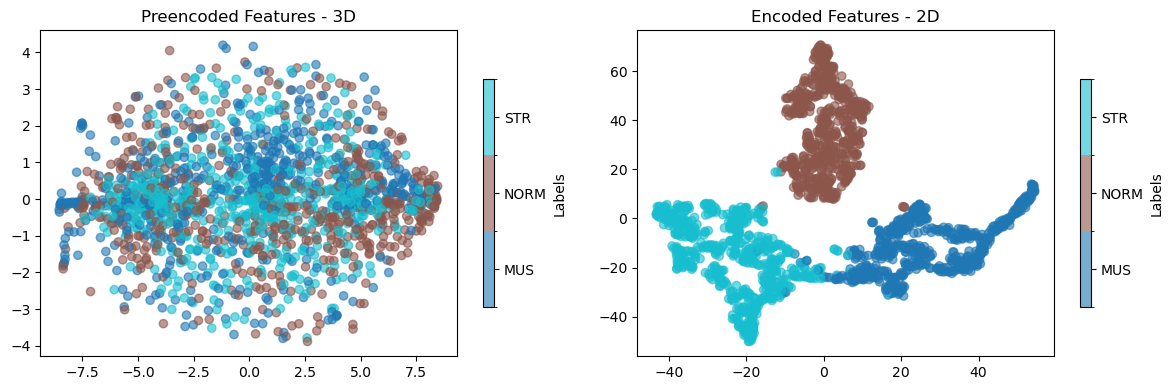

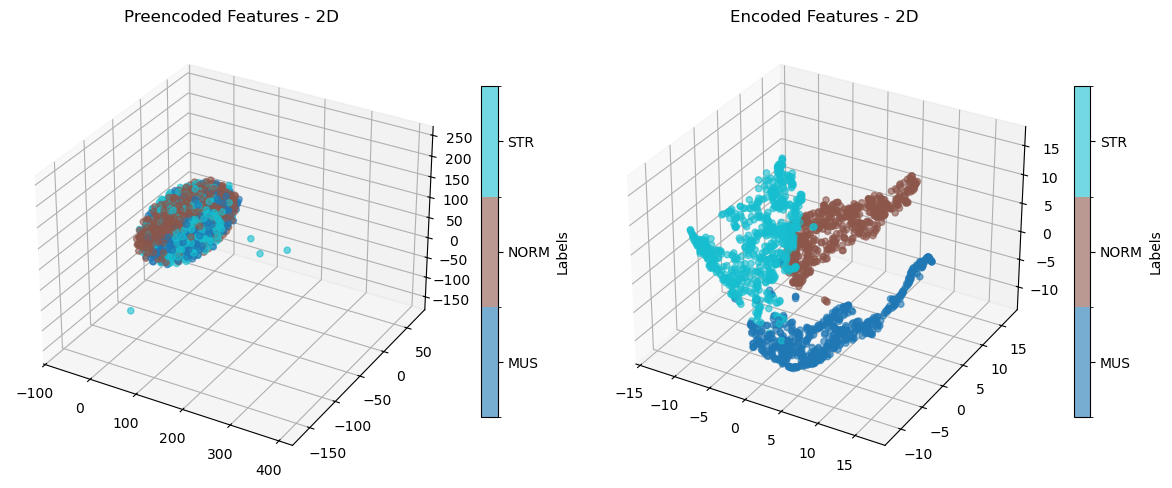

In [13]:
encoded_tsne_2d,encoded_tsne_3d,preencoded_tsne_2d,preencoded_tsne_3d,preencoded_features,encoded_features,labels_list = encoding(model,test_loader, device)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_tsne_2d(preencoded_tsne_2d, encoded_tsne_2d, labels_list, axs, label_tags_colorectal, fig)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 10))
plot_tsne_3d(preencoded_tsne_3d, encoded_tsne_3d,labels_list,label_tags_colorectal, fig)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

## TASK 2

---

- Visualize feature extraction for Dataset 2 and 3.  
    1. Using our trained ResNet-34 on Dataset 1
    2. Using pre-trained ResNet-34 on IMAGENET

- Train on classical ML model


### Defining Pre-trained ImageNet Model

In [14]:
# Initializing ResNet-34 pre-trained on IMAGENET
model_on_imageNet = resnet34(weights='IMAGENET1K_V1')

### Dataset 2
- loading data
- visualize extracted features from prerained model

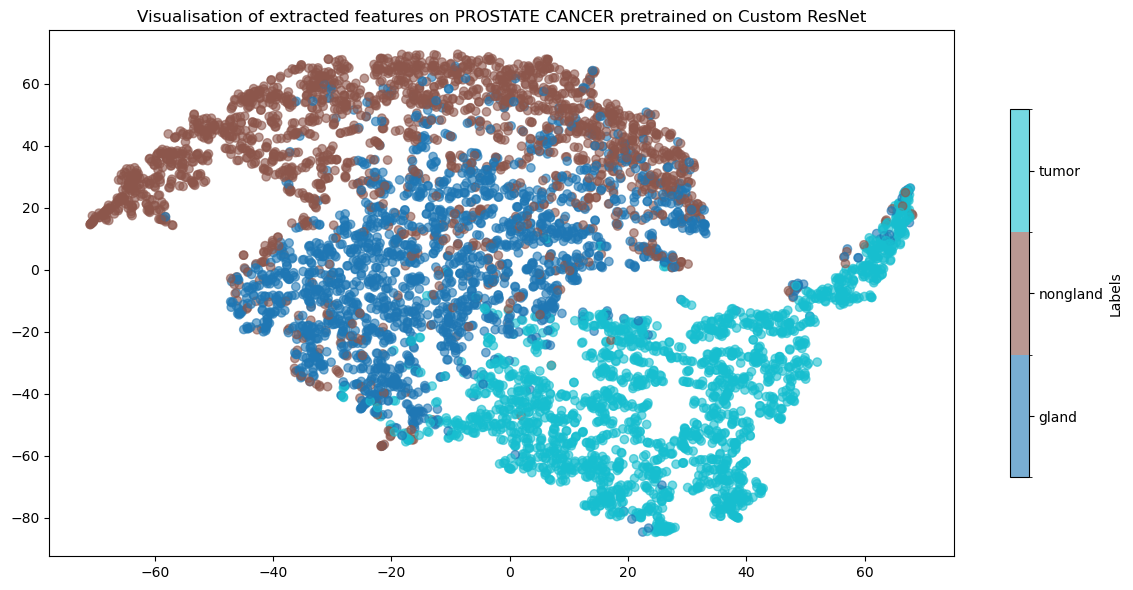

In [16]:
# load data
prostate_full_loader = full_data_loader(dataset_prostate_path, batch_size=64)

# visualize extracted features from prerained Restnet-34 model
trained_resnet_prostate_ef = visualize(model,prostate_full_loader,label_tags_prostate,'Visualisation of extracted features on PROSTATE CANCER pretrained on Custom ResNet', device)


### Pre-Trained ImageNet model

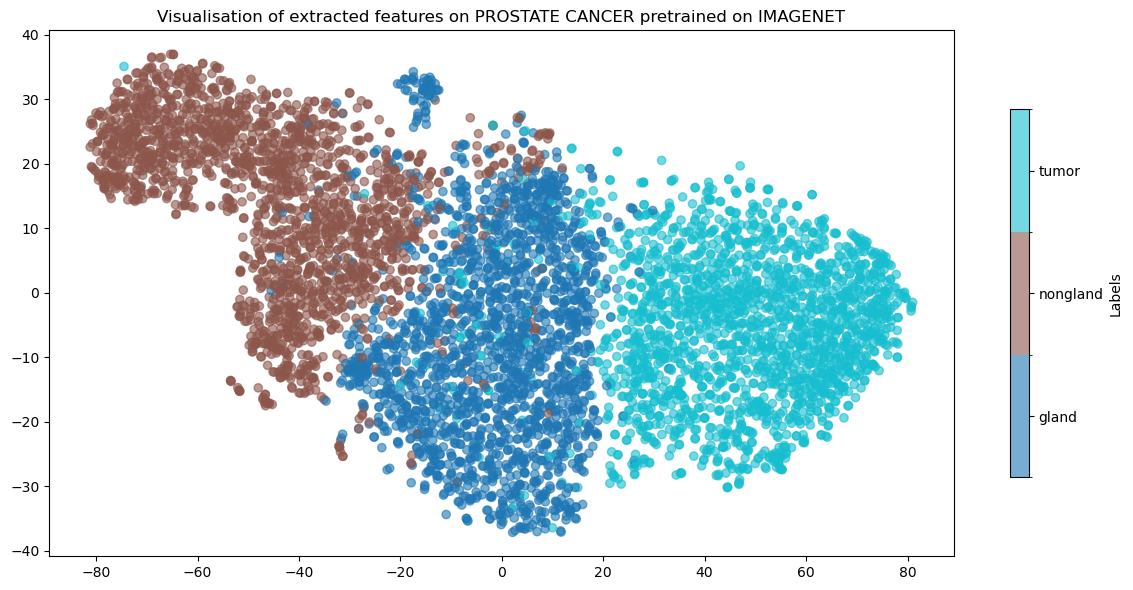

In [17]:
prostate_extracted_features = visualize(model_on_imageNet,prostate_full_loader,label_tags_prostate,'Visualisation of extracted features on PROSTATE CANCER pretrained on IMAGENET', device)

## Dataset 3

In [18]:
animal_full_loader = full_data_loader(dataset_animal_path, batch_size=64)

### Trained Restnet-34 model

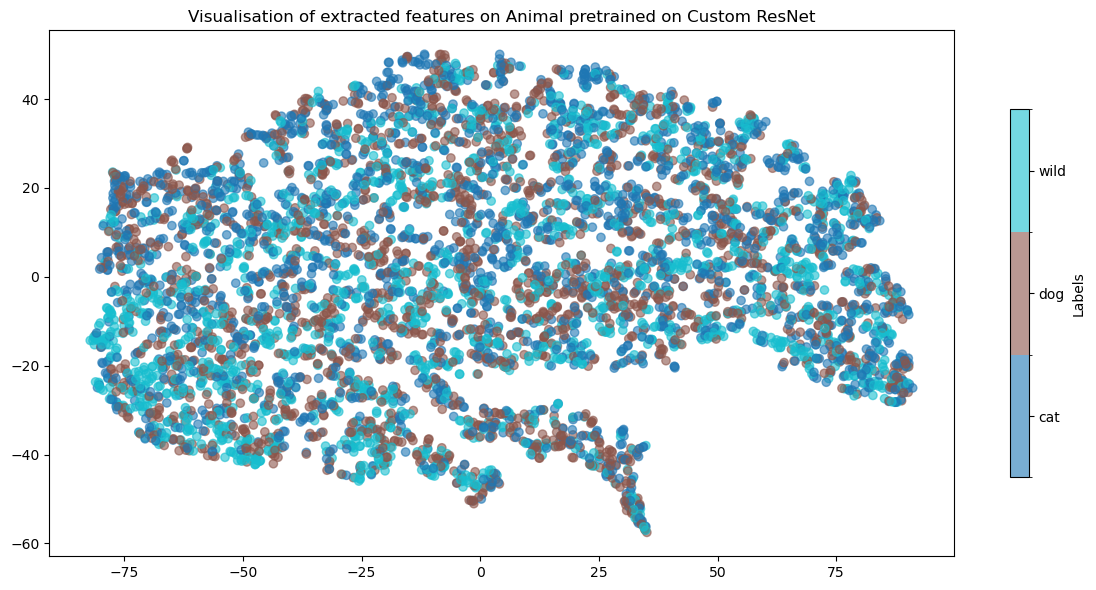

In [19]:
custom_resnet_animal_ef = visualize(model,animal_full_loader,label_tags_animals,'Visualisation of extracted features on Animal pretrained on Custom ResNet', device)

### Pre-Trained ImageNet model

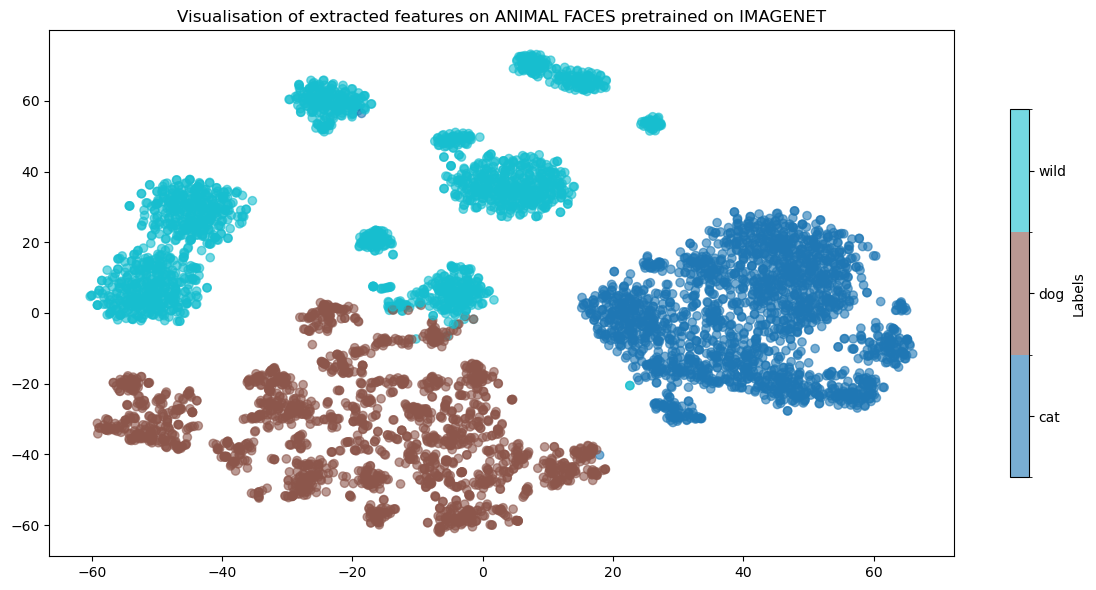

In [20]:
animal_extracted_features = visualize(model_on_imageNet,animal_full_loader,label_tags_animals,'Visualisation of extracted features on ANIMAL FACES pretrained on IMAGENET', device)

## Classification

### Classification using Random Forest for Dataset 2


Random Forest Accuracy: 96.08%
              precision    recall  f1-score   support

       gland       0.94      0.95      0.95       397
    nongland       0.97      0.97      0.97       384
       tumor       0.98      0.95      0.97       419

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



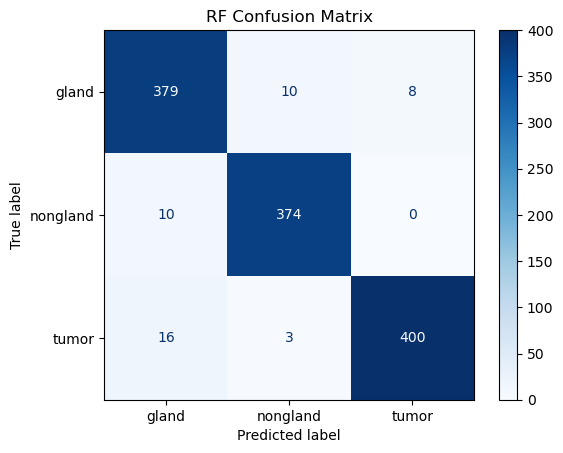

In [22]:
features, labels = save_features(prostate_full_loader,prostate_extracted_features,device)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_2d, labels, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_tags_prostate))

plot_confusion_matrix(y_test, y_pred, "RF Confusion Matrix", label_tags_prostate)

### Classification using SVM for dataset 3

SVM Accuracy: 98.92%
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       401
         dog       1.00      0.98      0.99       401
        wild       0.97      0.99      0.98       398

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



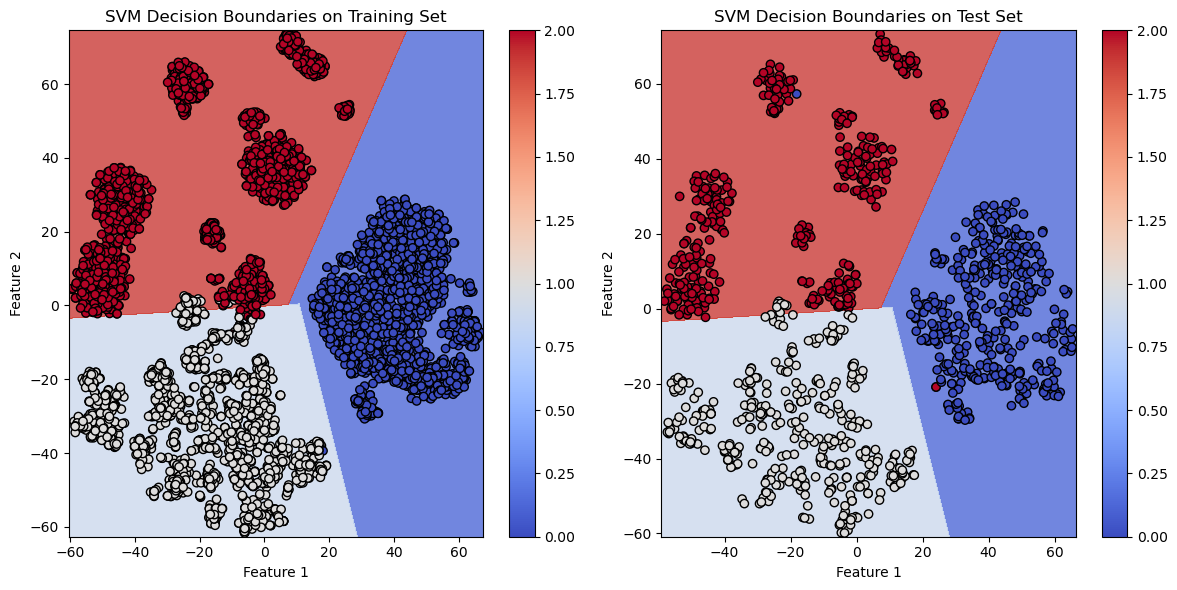

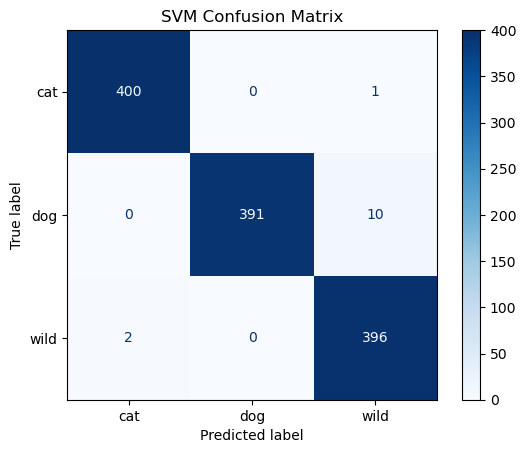

In [24]:

features, labels = save_features(animal_full_loader,animal_extracted_features, device)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_2d, labels, test_size=0.2, random_state=42)

#Training
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_tags_animals))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_decision_boundaries(X_train, y_train, svm_clf, "SVM Decision Boundaries on Training Set", axes[0])

plot_decision_boundaries(X_test, y_test, svm_clf, "SVM Decision Boundaries on Test Set", axes[1])

plt.tight_layout()

plot_confusion_matrix(y_test, y_pred, "SVM Confusion Matrix", label_tags_animals)